In [1]:
# if necessary, install NeuralGCM and dependencies
!python --version
!pip install -q -U neuralgcm dinosaur-dycore gcsfs
!pip install matplotlib
!pip install cartopy

Python 3.11.10


# Forecasting quick start

This notebook uses ERA5 data and pretrained NeuralGCM model to make a weather forecast.

The forecast is made in 3 steps:
1. Slice of ERA5 data is regridded to model resolution
2. NeuralGCM model state is initialized and rolled out
3. Predictions and reference trajectory are combined for visualization

By default the notebook uses intermediate deterministic NeuralGCM 1.4° model. Other available checkpoints include deterministic 0.7°, 2.8° and stochastic 1.4° NeuralGCM variations.

```{tip}
You can run this notebook yourself in [Google Colab](https://colab.research.google.com/github/google-research/neuralgcm/blob/main/docs/inference_demo.ipynb). We recommend using a GPU or TPU runtime due to high memory and compute requirements.
```

<span style="color:green">NEW</span> Added import for image display, see at end of document \
<span style="color:green">New</span> You Need to install module cartopy

In [2]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

import matplotlib.pyplot as plt
import cartopy

from PIL import Image
from IPython.display import display

gcs = gcsfs.GCSFileSystem(token='anon')

In [3]:
! pip install xarray netCDF4 numpy

import xarray as xr

ersst_path = "./data/tos_Omon_GISS-E2-1-G_historical_r1i1p5f1_gn_200101-201412.nc"
ersst_data = xr.open_dataset(ersst_path)

Subset the data to be similar to NeuralGCM

## Load a pre-trained NeuralGCM model

```{caution}
Trained model weights are licensed for non-commercial use, under the Creative Commons [Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/) license (CC BY-NC-SA 4.0).
```

Pre-trained model checkpoints from the NeuralGCM paper are [available for download](https://console.cloud.google.com/storage/browser/gresearch/neuralgcm/04_30_2024) on Google Cloud Storage:

- Deterministic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl`
- Stochastic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl`

## Need to train it on our own using the inputs from era5

In [4]:
drought_variables = [
    "precipitation",      # To track precipitation deficits
    "evaporation",        # Water loss through evaporation
    "soil_moisture",      # Soil water content for agricultural impacts
    "temperature",        # High temperatures linked to drought
    "specific_humidity",  # Tracks atmospheric moisture
    "surface_pressure",   # Indicator of regional pressure systems
    "sea_surface_temp",   # SST anomalies linked to teleconnections
]

## Load and modify the model configuration string

Ensure that the new variables (precipitation, soil moisture, evapotranspiration) are available in your dataset and properly preprocessed. The data should be regridded to match NeuralGCM's native grid and provided in the correct units. Refer to NeuralGCM's data preparation guidelines for detailed instructions.

In [5]:
gcs = gcsfs.GCSFileSystem(token='anon')
model_name = 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl'
with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
    ckpt = pickle.load(f)

new_inputs_to_units_mapping = {
    'u': 'meter / second',
    'v': 'meter / second',
    't': 'kelvin',
    'z': 'm**2 s**-2',
    'sim_time': 'dimensionless',
    'tracers': {'specific_humidity': 'dimensionless',
                'specific_cloud_liquid_water_content': 'dimensionless',
                'specific_cloud_ice_water_content': 'dimensionless',
    },

    'diagnostics': {
        'surface_pressure': 'kg / (meter s**2)',
        'sst_anomalies': 'kelvin',  # SST anomalies in Kelvin
        'P_minus_E_cumulative': 'kg / (meter**2)'
        # Add new diagnostic variables if any
    }
}

new_model_config_str = '\n'.join([
        ckpt['model_config_str'],
        f'DimensionalLearnedPrimitiveToWeatherbenchDecoder.inputs_to_units_mapping = {new_inputs_to_units_mapping}',
        'DimensionalLearnedPrimitiveToWeatherbenchDecoder.diagnostics_module = @NodalModelDiagnosticsDecoder',
        'StochasticPhysicsParameterizationStep.diagnostics_module = @PrecipitationMinusEvaporationDiagnostics',
        'PrecipitationMinusEvaporationDiagnostics.method = "cumulative"',
        'PrecipitationMinusEvaporationDiagnostics.moisture_species =  ("specific_humidity", "specific_cloud_liquid_water_content", "specific_cloud_ice_water_content")',])

ckpt['model_config_str'] = new_model_config_str

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

In [6]:
#model_name = 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl'  #@param ['neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl', 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'] {type: "string"}

#with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
#  ckpt = pickle.load(f)

#model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

## Load ERA5 data from GCP/Zarr

See {doc}`datasets` for details. Leave this part


Select out a few days of data:

## Need to change start time and end time

Checklist: \
<span style="color:green">NEW</span> Different lon und lat bounds \
<span style="color:red">Decide on start and end time</span> \

In [7]:
#era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
#full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

#used for training as it is short, however empty amo_index and could be a longer range 
#start_date = '2000-12-10'
#end_date = '2014-12-20'

#data_inner_steps = 24  # process every 24th hour

lat_bounds = [slice(34, 45), slice(34, 51)] 
lon_bounds = [slice(-25, 19), slice(-20, 10)]  

In [8]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

start_time = '2020-02-01'
end_time = '2020-02-16'
data_inner_steps = 24  # process every 24th hour


<span style="color:green"></span> Compute anomalies, trends, or indices such as the Atlantic Multidecadal Oscillation (AMO) to understand SST variations over time. \

In [9]:
# Subset the data
sst_subset = ersst_data['tos'].sel(time=slice(start_time, end_time),
                                   lat=lat_bounds[0],
                                   lon=lon_bounds[0])
print(sst_subset.values)

# Calculate the climatology (mean over the period)
sst_subset['time'] = sst_subset.indexes['time']

climatology = sst_subset.mean(dim='time') 

print(climatology)
print(climatology.dims)
print(climatology.shape)
# Compute SST anomalies
sst_anomalies = sst_subset - climatology

sst_anomalies.to_netcdf('sst_anomalies.nc')

# Calculate the AMO index (example)
amo_index = sst_anomalies.mean(dim=['lat', 'lon'])

print(amo_index)

[]
<xarray.DataArray 'tos' (lat: 6, lon: 8)> Size: 192B
array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 48B 35.0 37.0 39.0 41.0 43.0 45.0
  * lon      (lon) float64 64B 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75
('lat', 'lon')
(6, 8)
<xarray.DataArray 'tos' (time: 0)> Size: 0B
array([], dtype=float32)
Coordinates:
  * time     (time) object 0B 


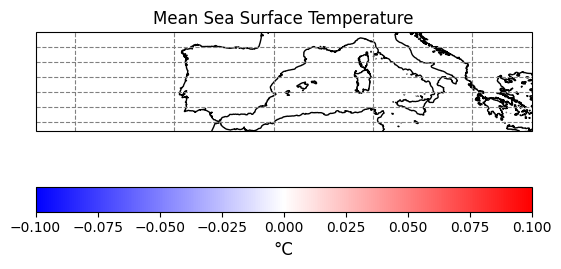

In [10]:
region = [-24, 26, 35, 45] 

plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=0))
ax.set_global()
ax.set_extent(region, crs=cartopy.crs.PlateCarree())
ax.gridlines(linestyle='--',color='gray')
ax.coastlines()

temp_cartopy = ax.pcolormesh(
    sst_subset['lon'], 
    sst_subset['lat'], 
    climatology, 
    transform=cartopy.crs.PlateCarree(), 
    shading='auto', 
    cmap='bwr'
)
colorbar = plt.colorbar(temp_cartopy, ax=ax, orientation='horizontal', label='Mean Temperature')
colorbar.set_label("°C",size=12,rotation=0)
plt.title("Mean Sea Surface Temperature")
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

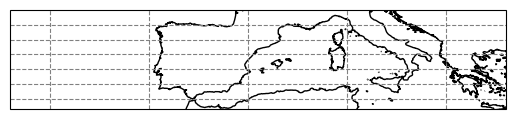

In [11]:
plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=0))
ax.set_global()
ax.set_extent(region, crs=cartopy.crs.PlateCarree())
ax.gridlines(linestyle='--',color='gray')
ax.coastlines()

temp_cartopy = ax.pcolormesh(sst_subset['lon'], sst_subset['lat'], sst_anomalies[0,:,:], transform=cartopy.crs.PlateCarree(), shading='auto',cmap='bwr')
colorbar = plt.colorbar(temp_cartopy, ax=ax, orientation='horizontal', label='SST Anomalies')
colorbar.set_label("°C",size=12,rotation=0)
plt.title("SST Anomalies")
plt.show()

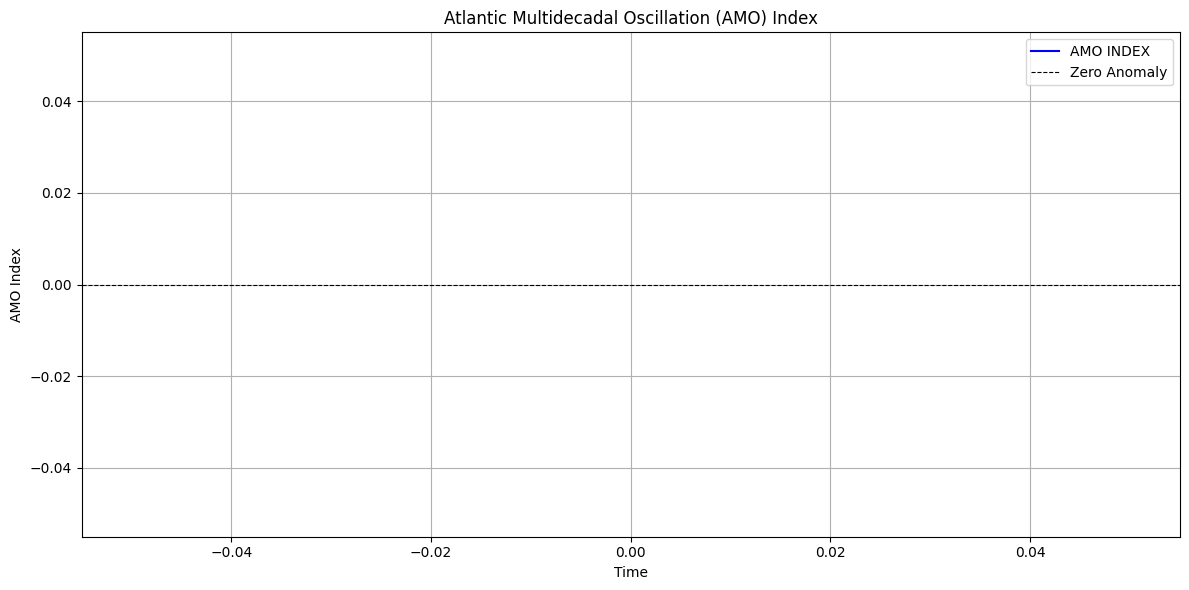

In [12]:
plt.figure(figsize=(12,6))
plt.plot(amo_index, label="AMO INDEX", color="b")
plt.axhline(0, color="k", linestyle="--", linewidth=0.8, label="Zero Anomaly")
plt.title("Atlantic Multidecadal Oscillation (AMO) Index")
plt.xlabel("Time")
plt.ylabel("AMO Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<span style="color:green"></span>Incorporate the processed SST data or derived indices into your drought prediction model as predictors or covariates.

In [13]:
#sst_anomalies = sst_anomalies.rename({'lat': 'latitude', 'lon': 'longitude'})
print(sst_anomalies)
print(sst_anomalies.dims)
# Ensure SST is present
if 'sea_surface_temperature' not in full_era5:
    raise ValueError("SST variable not found in the dataset!")

<xarray.DataArray 'tos' (time: 0, lat: 6, lon: 8)> Size: 0B
array([], shape=(0, 6, 8), dtype=float32)
Coordinates:
  * lat      (lat) float64 48B 35.0 37.0 39.0 41.0 43.0 45.0
  * lon      (lon) float64 64B 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75
  * time     (time) object 0B 
('time', 'lat', 'lon')


In [14]:
print(full_era5["mean_total_precipitation_rate"])
for i in full_era5:
    if "wind" in i:
        print(i)

<xarray.DataArray 'mean_total_precipitation_rate' (time: 1323648,
                                                   latitude: 721,
                                                   longitude: 1440)> Size: 5TB
[1374264299520 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00
Attributes:
    long_name:   Mean total precipitation rate
    short_name:  mtpr
    units:       kg m**-2 s**-1
100m_u_component_of_wind
100m_v_component_of_wind
10m_u_component_of_neutral_wind
10m_u_component_of_wind
10m_v_component_of_neutral_wind
10m_v_component_of_wind
10m_wind_gust_since_previous_post_processing
instantaneous_10m_wind_gust
mean_direction_of_wind_waves
mean_period_of_wind_waves
mean_wave_period_based_on_first_moment_for_wind_waves
mean_wave_period_based_on_second_moment_for_

<span style="color:green">NEW</span> Add SST anomalies to the input variables of the NeuralGCM model
<span style="color:green">TODO</span> Error with too much data -> sliced or maybe on cluster

In [15]:
import pandas as pd
#print("Dimensions:", full_era5.dims)
#print(lat_bounds)
#print("Latitude values:", full_era5['latitude'].values)
#print(lon_bounds)
#print("Coordinates:", full_era5.coords)


# Reassign 'dim_0' as the dimension for 'time'
#if "time" in full_era5.coords:
#    full_era5 = full_era5.swap_dims({"dim_0": "time"})

# Verify the change
print("Updated Dimensions:", full_era5.dims)
print("Updated Coordinates:", full_era5.coords)

# Step 1: Subset the region and time range

time_bounds = slice('2000-01-01' ,'2020-12-31')
lat_bounds = slice(51, 34)  # Latitude bounds (51°N to 34°N)
lon_bounds = slice(-20, 10)  # Longitude bounds (-20°W to 10°E)

subset = full_era5.sel(latitude=lat_bounds, longitude=lon_bounds, time=time_bounds)


# # Add SST anomalies and other relevant inputs to the dataset
# era5_with_sst = xr.Dataset(
#     {
#         'precipitation': subset.get('mean_total_precipitation_rate', None),
#         'temperature': subset.get('temperature', None),
#         'specific_humidity': subset.get('specific_humidity', None),
#         'sst_anomalies': sst_anomalies,
#         'evapotranspiration': subset.get('evaporation', None),
#         'soil_moisture': subset.get('volumetric_soil_water_layer_1', None),
#         'surface_pressure': subset.get('surface_pressure', None),
#     },
#     coords={
#         'time': subset['time'],
#         'latitude': subset['latitude'],
#         'longitude': subset['longitude'],
#     }
# )

# # Display the resulting smaller dataset
# print("Final dataset dimensions and variables:")
# print(era5_with_sst)

# era5_with_sst.to_netcdf("era5_with_sst.nc")


Updated Dimensions: FrozenMappingWarningOnValuesAccess({'time': 1323648, 'latitude': 721, 'longitude': 1440, 'level': 37})
Updated Coordinates: Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * level      (level) int64 296B 1 2 3 5 7 10 20 ... 875 900 925 950 975 1000
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00


In [16]:

# Load SST anomalies dataset
# sst_anomalies_ds = xr.open_dataset('sst_anomalies.nc')
# sst_anomalies_ds = sst_anomalies_ds.sel(
#    time=era5_ds.time, 
#    method='nearest'
#)

#era5_combined = xr.merge([era5_ds, sst_anomalies_ds])

Regrid to NeuralGCM's native resolution: <span style="color:red">Rewrite it to use the sst data</span>.

In [17]:
#start_date_test = "2014-12-10"
#end_date_test = "2014-12-20"

##old code#

#sliced_era5 = (
#    full_era5[['mean_total_precipitation_rate', 'temperature']]
#    .pipe(
#        xarray_utils.selective_temporal_shift,
#        variables=[],
#        time_shift='24 hours',
#    )
#    .sel(time=slice(start_date, end_date, data_inner_steps))
#    .compute()
#)


#sliced_era5['sst_anomalies'] = sst_anomalies.sel(
#    time=slice(start_date, end_date)
#)

In [18]:
#sst = full_era5['sea_surface_temperature'].sel(latitude=lat_bounds, longitude=lon_bounds, time=time_bounds).fillna(0)

In [19]:
sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(start_time, end_time, data_inner_steps))
    .compute()
)


In [20]:
##old code#

print(sst_anomalies.values)
sst_anomalies = sst_anomalies.fillna(0)
print(sst_anomalies.values)

#sliced_era5['sst_anomalies'] = sst_anomalies.sel(
#    time=slice(start_date, end_date)
#)

era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)

regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
    
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

# Regrid SST
#sst_regridded = xarray_utils.regrid(sst, regridder)

# Add SST to the regridded ERA5 dataset
#sliced_era5['sea_surface_temperature'] = sst_regridded

#eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
#eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

[]
[]


In [21]:
# sliced_era5 = (
#     full_era5[['mean_total_precipitation_rate', 'temperature', "geopotential", 
#                "specific_humidity", "u_component_of_wind", "v_component_of_wind", 
#                "specific_cloud_ice_water_content", "specific_cloud_liquid_water_content", 
#                "sea_ice_cover", "sea_surface_temperature"]]
#     .pipe(
#         xarray_utils.selective_temporal_shift,
#         variables=[],
#         time_shift='24 hours',
#     )
#     .sel(time=slice(start_date, end_date, data_inner_steps))
#     .compute()
# )

# sst = full_era5['sea_surface_temperature'].fillna(0)

# sst_filled = xarray_utils.fill_nan_with_nearest(full_era5['sea_surface_temperature'])

# # Define NeuralGCM grid
# model_grid = spherical_harmonic.Grid(
#     latitude_nodes=full_era5.sizes['latitude'],
#     longitude_nodes=full_era5.sizes['longitude'],
#     latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
#     longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
# )

# # Create regridder
# regridder = horizontal_interpolation.ConservativeRegridder(
#     source_grid=model_grid,
#     target_grid=model_grid,
#     skipna=True
# )

# # Regrid SST
# sst_regridded = xarray_utils.regrid(sst, regridder)

# # Add SST to the regridded ERA5 dataset
# sliced_era5['sea_surface_temperature'] = sst_regridded


In [22]:
print(sst_anomalies.dims)
print(sst_anomalies)

('time', 'lat', 'lon')
<xarray.DataArray 'tos' (time: 0, lat: 6, lon: 8)> Size: 0B
array([], shape=(0, 6, 8), dtype=float32)
Coordinates:
  * lat      (lat) float64 48B 35.0 37.0 39.0 41.0 43.0 45.0
  * lon      (lon) float64 64B 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75
  * time     (time) object 0B 


<span style="color:green">NEW</span>:Ensure that the combined dataset adheres to NeuralGCM’s expected format.

In [23]:
#model_inputs = {
#    variable: era5_with_sst[variable].values for variable in era5_with_sst.data_vars
#}

## Make the forecast

See {doc}`trained_models` for details.

In [24]:
import signal
import sys
import numpy as np
import jax

# Parameters for 30-year rollout
years = 30
days_per_year = 365  # Exclude leap years for simplicity
inner_steps = 24  # Save model outputs every 24 hours
hours_per_day = 24
outer_steps = (days_per_year * years * hours_per_day) // inner_steps  # Total steps for 30 years
timedelta = np.timedelta64(inner_steps, 'h')  # Time interval between model outputs
times = np.arange(outer_steps) * inner_steps  # Time axis in hours

# Placeholder model and data (replace with actual implementations)
# model = ...
# eval_era5 = ...

class GracefulExit:
    """Handles graceful exit and file closing."""
    def __init__(self, file):
        self.file = file
        self.is_running = True

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.cleanup()

    def cleanup(self):
        print("Shutting down gracefully...")
        if not self.file.closed:
            self.file.close()
        self.is_running = False

# Signal handler to trigger cleanup
def handle_signal(signum, frame):
    global graceful_exit_context
    graceful_exit_context.cleanup()

# Register signal handlers
signal.signal(signal.SIGINT, handle_signal)
signal.signal(signal.SIGTERM, handle_signal)

output_file = "30_year_rollout_predictions.nc"

with open(output_file, "w") as nc_file:
    with GracefulExit(nc_file) as graceful_exit_context:
        try:
            # Initialize model state
            print("Initializing model state...")
            inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
            input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
            rng_key = jax.random.key(42)  # Optional for deterministic models
            initial_state = model.encode(inputs, input_forcings, rng_key)

            # Use persistence for forcing variables (e.g., SST and sea ice cover)
            print("Using persistent forcing variables...")
            all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

            # Make forecast
            print(f"Starting 30-year rollout with {outer_steps} steps...")
            final_state, predictions = model.unroll(
                initial_state,
                all_forcings,
                steps=outer_steps,
                timedelta=timedelta,
                start_with_input=True,
            )

            # Convert predictions to xarray dataset
            print("Converting predictions to xarray.Dataset...")
            #print(predictions)
            predictions_ds = model.data_to_xarray(predictions, times=times)
            print(predictions_ds)
            # Save results to a NetCDF file
            print("Applying chunking to the dataset...")
            #chunked_ds = predictions_ds.chunk({'time': 100})  # Adjust chunk size as needed
            #chunked_ds.to_netcdf(output_file, mode='w', engine='netcdf4')


            # Final message
            print("30-year rollout completed successfully.")

        except Exception as e:
            print(f"An error occurred: {e}")
            graceful_exit_context.cleanup()
        finally:
            print("Execution stopped.")


Initializing model state...
Using persistent forcing variables...
Starting 30-year rollout with 10950 steps...
Converting predictions to xarray.Dataset...
<xarray.Dataset> Size: 93GB
Dimensions:                              (time: 10950, longitude: 128,
                                          latitude: 64, level: 37)
Coordinates:
  * longitude                            (longitude) float64 1kB 0.0 ... 357.2
  * latitude                             (latitude) float64 512B -87.86 ... 8...
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * time                                 (time) int64 88kB 0 24 ... 262776
Data variables:
    P_minus_E_cumulative                 (time, longitude, latitude) float32 359MB ...
    geopotential                         (time, level, longitude, latitude) float32 13GB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 13GB ...
    specific_humidity                    (time, level, longitud

## Compare forecast to ERA5

See [WeatherBench2](https://sites.research.google/weatherbench/) for more comprehensive evaluations and archived NeuralGCM forecasts.

Can stay like this

In [25]:
# Selecting ERA5 targets from exactly the same time slice
target_trajectory = model.inputs_from_xarray(
    eval_era5
    .thin(time=(inner_steps // data_inner_steps))
    .isel(time=slice(outer_steps))
)
target_data_ds = model.data_to_xarray(target_trajectory, times=times)

combined_ds = xarray.concat([target_data_ds, predictions_ds], 'model')
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

ValueError: Value of shape (16, 37, 128, 64) is not in shape_to_dims={(10950,): ('time',), (10950, 37, 127, 65): ('time', 'level', 'longitudinal_mode', 'total_wavenumber'), (10950, 37, 128, 64): ('time', 'level', 'lon', 'lat'), (10950, 128, 64): ('time', 'lon', 'lat'), (10950, 127, 65): ('time', 'longitudinal_mode', 'total_wavenumber'), (10950, 1, 128, 64): ('time', 'surface', 'lon', 'lat'), (10950, 1, 127, 65): ('time', 'surface', 'longitudinal_mode', 'total_wavenumber'), (10950, 1): ('time', 'surface')}

In [ ]:
# Visualize ERA5 vs NeuralGCM trajectories
combined_ds.specific_humidity.sel(level=850).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
);

## Data Analysis

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import norm
from numba import jit

In [ ]:
@jit
def thornthwaite(temp, lat):
    """Calculate Potential Evapotranspiration (PET) using Thornthwaite's equation."""
    N = len(temp)
    I = sum((temp[temp > 0] / 5) ** 1.514)  # Monthly temperature index
    a = (6.75e-7 * I ** 3) - (7.71e-5 * I ** 2) + (1.792e-2 * I) + 0.49239
    PET = np.zeros(N)
    for i in range(N):
        if temp[i] > 0:
            L = 12  # Assume 12 hours of daylight on average
            PET[i] = (16 * ((10 * temp[i] / I) ** a) * (L / 12))
    return PET


In [ ]:
print("Calculating PET...")
predictions_ds['PET'] = xr.apply_ufunc(
    thornthwaite,
    predictions_ds['temperature'],
    kwargs={'lat': 45},  # Replace 45 with the actual latitude if available
    vectorize=True
)


In [ ]:
print("Calculating D (P - PET)...")
predictions_ds['D'] = predictions_ds['P_minus_E_cumulative'] - predictions_ds['PET']

In [ ]:
def compute_spei(D, scale=3):
    """Compute SPEI at a given scale (e.g., 3-month rolling)."""
    rolling_mean = D.rolling(time=scale, center=False).mean()
    rolling_std = D.rolling(time=scale, center=False).std()
    spei = (rolling_mean - rolling_mean.mean(dim="time")) / rolling_std
    return spei

print("Calculating SPEI...")
predictions_ds['SPEI'] = compute_spei(predictions_ds['D'])

In [ ]:
#Plot SPEI
def plot_spei(spei, lat=0, lon=0):
    """Plot SPEI time series for a given location."""
    spei_point = spei.sel(latitude=lat, longitude=lon, method="nearest")
    plt.figure(figsize=(10, 6))
    spei_point.plot(label="SPEI")
    plt.axhline(0, color="k", linestyle="--", linewidth=1)
    plt.title(f"SPEI at Location (lat: {lat}, lon: {lon})")
    plt.xlabel("Time")
    plt.ylabel("SPEI")
    plt.legend()
    plt.grid()
    plt.show()

# Example plot for a specific location (adjust latitude/longitude)
print("Plotting SPEI for (lat=0, lon=0)...")
plot_spei(predictions_ds['SPEI'], lat=45, lon=20)


## Adding later

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open('images/Spain_range_1.png')
display(img)

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open('images/Spain_range_1.png')
display(img)

In [ ]:
img = Image.open('images/Spain_range_1.png')
display(img)